In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from diffusers import DDPMPipeline, DDIMScheduler, DDPMScheduler
from datasets import load_dataset
import matplotlib.pyplot as plt

device = (
    'mps' if torch.backends.mps.is_available()  # MPS: Multi-Process Service,目前只支持Linux
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(f'Using device: {device}')

Using device: cuda


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

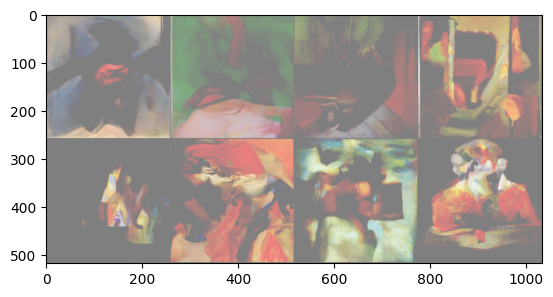

In [2]:

pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(8, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)
    
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(0, 1) *0.5 + 0.5)

In [3]:
def color_loss(images, target_color=(0.1, 0.9, 0.5)):

    target = (
        torch.tensor(target_color).to(images.device) * 2 - 1
    )
    target = target[
        None, :, None, None
    ]   # 将target的shape变为(1, 3, 1, 1)
    # print(target.shape)

    # 均方误差
    error = torch.mean(
        (images - target) ** 2
    )

    # error = torch.abs(
    #     images - target
    # ).mean()  # 书上原先代码，似乎有问题

    return error

  0%|          | 0/40 [00:00<?, ?it/s]

0 loss: 12.990367889404297
10 loss: 4.061756610870361
20 loss: 4.016733169555664
30 loss: 4.1532511711120605


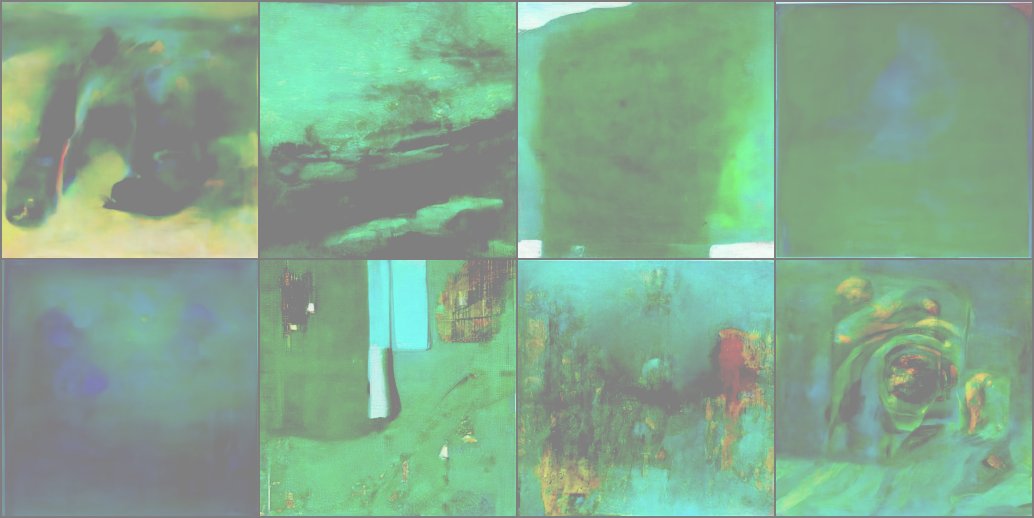

In [4]:
# 采样实现方式：
# 方式一：从UNet中获取噪声预测，并将其设置为输入图像x的requires_grad属性，这样就可以更高效地使用内存了，但会降低梯度的精度
# 方式二：先将输入图像x的requires_grad属性设置为True，然后传递给UNet并计算“去噪”后的图像x0

# 方式一：
guidance_loss_scale = 20

x = torch.randn(8, 3, 256, 256).to(device)
process_x = []
for i, t in tqdm(enumerate(scheduler.timesteps),
                 total=len(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    x = x.detach().requires_grad_()

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())
        
    cond_grad = -torch.autograd.grad(loss, x)[0]

    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample
    if i % 10 == 0:
        process_x.append(x)
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(0, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))



# for x in process_x:
#     grid = torchvision.utils.make_grid(x, nrow=4)
#     im = grid.permute(1, 2, 0).cpu().clip(0, 1) * 0.5 + 0.5
#     img = Image.fromarray(np.array(im * 255).astype(np.uint8))
#     plt.imshow(img)
#     plt.show()

0it [00:00, ?it/s]

0 loss: 29.18714141845703
10 loss: 9.936544418334961
20 loss: 8.788939476013184
30 loss: 9.104959487915039


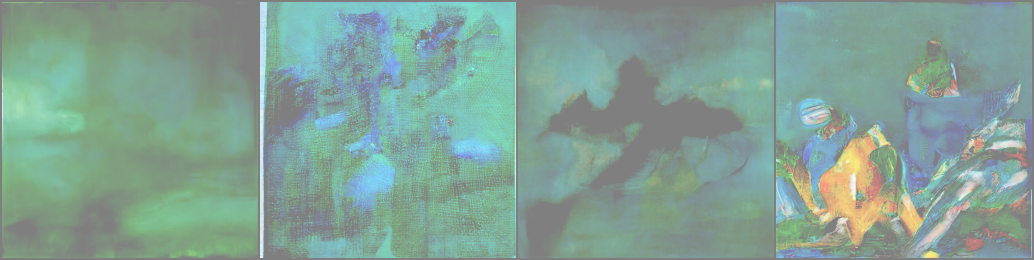

In [5]:
# 方式二：
guidance_loss_scale = 40
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):

    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)

    noise_pred = image_pipe.unet(model_input, t)["sample"]

    x0 = scheduler.step(noise_pred, t, x).pred_original_sample

    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(i, "loss:", loss.item())

    cond_grad = -torch.autograd.grad(loss, x)[0]

    x = x.detach() + cond_grad

    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(0, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))



In [6]:
# CLIP引导
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(device)

# 
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # 随机裁剪
        torchvision.transforms.RandomAffine(5), # 随机扭曲图片
        torchvision.transforms.RandomHorizontalFlip(),  # 随机左右镜像

        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        )
    ]
)

#
def clip_loss(image, text_features):
    
    image_features = clip_model.encode_image(
        tfms(image)
    )

    input_normed = torch.nn.functional.normalize(
        image_features.unsqueeze(1), dim=2
    )
    embed_normed = torch.nn.functional.normalize(
        text_features.unsqueeze(0), dim=2
    )
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )   # 使用 Squared Great Circle Distance 计算图像和文本之间的距离

    return dists.mean()


100%|███████████████████████████████████████| 354M/354M [03:08<00:00, 1.88MiB/s]


  0%|          | 0/50 [00:00<?, ?it/s]

Step: 0 , Guidance loss: 7.421110153198242
Step: 25 , Guidance loss: 7.191967487335205


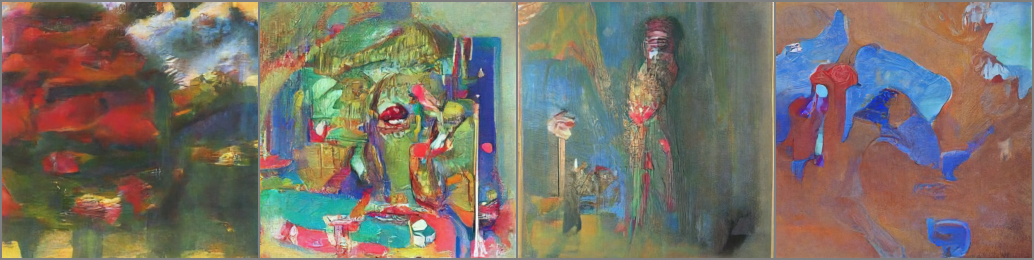

In [9]:
prompt = "Red Rose (still life), red flower painting"

guidance_scale = 8
n_cuts = 4  # n_cuts是指在每个时间步长上进行的迭代次数
scheduler.set_timesteps(50)

# 使用CLIP从提示文字中提取特征
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0
    
    for cut in range(n_cuts):

        # 设置输入图像的requires_grad属性为True
        x = x.detach().requires_grad_()

        # 获得"去噪"后的图像
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        loss = clip_loss(x0, text_features) * guidance_scale

        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

        # 根据梯度更新x
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )
    
    # 使用调度器更新x
    x = scheduler.step(noise_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))


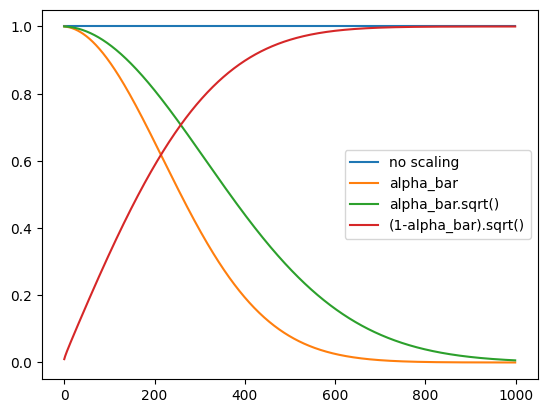

In [10]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha_bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha_bar.sqrt()")
plt.plot(
    [(1-a).sqrt() for a in scheduler.alphas_cumprod], label="(1-alpha_bar).sqrt()"
)

plt.legend()

In [12]:
# 使用gradio分享你的模型
import gradio as gr
from PIL import Image, ImageColor

# generate函数用于生成图片
def generate(color, guidance_loss_scale):
    
    target_color = ImageColor.getcolor(color, "RGB")
    target_color = [a / 255 for a in target_color]
    x = torch.randn(1, 3, 256, 256).to(device)

    for i, t in tqdm(enumerate(scheduler.timesteps)):

        model_input = scheduler.scale_model_input(x, t)

        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]

        x = x.detach().requires_grad_()
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = -torch.autograd.grad(loss, x)[0]
        
        x = x.detach() + cond_grad
        x = scheduler.step(noise_pred, t, x).prev_sample
    
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(0, 1) * 0.5 + 0.5
    im = Image.fromarray(np.array(im * 255).astype(np.uint8))
    im.save("test.jpeg")
    return im

inputs = [
    gr.ColorPicker(label="color", value="55FFAA"),
    gr.Slider(label="guidance_loss_scale", minimum=0, maximum=30, value=3),
    
]

outputs = gr.Image(label="result")

# minimal interface
demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],
    ],
)

demo.launch(debug=True) # debug=True,可以在本地运行，否则会在浏览器中打开

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


0it [00:00, ?it/s]